# Análise do Data Warehouse

Análise dos dados disponibilizados no Data Warehouse



**Instalando o Cassandra no Jupyter**

`docker-compose exec jupyter pip install cassandra-driver`

## Imports

In [1]:
#Imports
from time import sleep

In [2]:
#Imports Cassandra
from cassandra.auth import PlainTextAuthProvider
from cassandra.cluster import Cluster

In [3]:
#Imports Pandas
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

## Conexão ao banco de Dados Cassandra

In [4]:
#Conectando a seção
ap = PlainTextAuthProvider(username='cassandra', password='cassandra')
cluster = Cluster(['cassandra'], protocol_version=4, auth_provider=ap)
session = cluster.connect('alunos')
session.default_timeout = 60
session.row_factory = pandas_factory
sleep(2)

## Consulta

### Configurando a consulta
Atribuindo valores para as consultas

In [5]:
table = 'fato_aluno_renda'
field = 'renda_familiar'
curse_types = ['Técnico']
filters = {    
    'categoria_situacao': ['Evadidos','Concluintes'],
    field: True,
    'tipo_curso': len(curse_types) > 0,
    'instituicao': 'IFPB',
    'unidade_ensino': '',
    'nome_curso': '',
    
}

### Construindo a string para a consulta
Criando fields e grupos para a consulta

In [6]:
s = []
gf = []
for k, v in filters.items():
    if v :
        if type(v) is str:
            s.append("({} = '{}')".format(k,v))            
        elif type(v) is list:
            s.append("({} IN ({}))".format(
                k,','.join(map(str,["'{}'".format(i) for i in v]))))
        if (type(v) is bool and v) or (not type(v) is bool):
            gf.append(k)
filter_sql = " AND ".join(map(str,s))
fields = ", ".join(map(str,gf))


### Execultado a consulta

In [7]:
#Execultado Consulta
sql = "SELECT {0}, sum(quant_grupo) AS quant_grupo" \
" FROM {1} " \
" WHERE {2} " \
" GROUP BY {0}" \
" ALLOW FILTERING;".format(
    fields,
    table,
    filter_sql)
rslt = session.execute(sql, timeout=None)
original_df = rslt._current_rows
original_df


,categoria_situacao,renda_familiar,tipo_curso,instituicao,quant_grupo
0,Concluintes,"0,5<RFP<=1,0",Bacharelado,IFPB,51
1,Concluintes,"0,5<RFP<=1,0",Especialização (Lato Sensu),IFPB,50
2,Concluintes,"0,5<RFP<=1,0",Licenciatura,IFPB,37
3,Concluintes,"0,5<RFP<=1,0",Mestrado,IFPB,2
4,Concluintes,"0,5<RFP<=1,0",Qualificação Profissional (FIC),IFPB,85
...,...,...,...,...,...
88,Evadidos,"RFP>3,5",Licenciatura,IFPB,9
89,Evadidos,"RFP>3,5",Mestrado Profissional,IFPB,1
90,Evadidos,"RFP>3,5",Qualificação Profissional (FIC),IFPB,1
91,Evadidos,"RFP>3,5",Tecnologia,IFPB,11


## Análise

In [8]:
s = original_df.shape
print("Número de registros {:,} e número de colunas {:,}.".format(s[0], s[1]).replace(',','.'))

Número de registros 93 e número de colunas 5.


## Filtrando Tipo do Curso

In [9]:
if curse_types :
    original_df = original_df[original_df['tipo_curso'].isin(curse_types)]
    print('Fitrando pelos tipos de cursos:\n {}'.format(', '.join(map(str,curse_types))))
    
else:
    print('Todos os cursos')
original_df

Fitrando pelos tipos de cursos:
 Técnico


,categoria_situacao,renda_familiar,tipo_curso,instituicao,quant_grupo
6,Concluintes,"0,5<RFP<=1,0",Técnico,IFPB,427
13,Concluintes,"0<RFP<=0,5",Técnico,IFPB,1760
19,Concluintes,"1,0<RFP<=1,5",Técnico,IFPB,138
26,Concluintes,"1,5<RFP<=2,5",Técnico,IFPB,44
33,Concluintes,"2,5<RFP<=3,5",Técnico,IFPB,16
40,Concluintes,NÃO DECLARADA,Técnico,IFPB,1105
46,Concluintes,"RFP>3,5",Técnico,IFPB,31
53,Evadidos,"0,5<RFP<=1,0",Técnico,IFPB,299
59,Evadidos,"0<RFP<=0,5",Técnico,IFPB,1597
65,Evadidos,"1,0<RFP<=1,5",Técnico,IFPB,80


## Agrupando

### Agrupando os valores para apresentar no gráfico

In [10]:
df = original_df.groupby(['categoria_situacao',field]).sum('quant_grupo').reset_index()
df_qtd = original_df.groupby([field]).sum('quant_grupo').reset_index()
order = list(df_qtd.sort_values('quant_grupo', ascending=False)[field])

### Ordenação personalizada

In [11]:
order = [
    '0<RFP<=0,5',
    '0,5<RFP<=1,0',
    '1,0<RFP<=1,5',
    '1,5<RFP<=2,5',
    '2,5<RFP<=3,5',
    'RFP>3,5',
    'NÃO DECLARADA'
]

### Ordenando dados

In [12]:
sort_keys = {v:k for k,v in enumerate(order)}
func_sort = lambda e: sort_keys[e]
df_cat = df.pivot_table('quant_grupo',[field],'categoria_situacao').sort_values(by=field, key=lambda col: col.map(func_sort))
df_qtd = df_qtd.pivot_table('quant_grupo',[field]).sort_values(by=field, key=lambda col: col.map(func_sort))

### Apresentando o gráfico

<AxesSubplot:xlabel='renda_familiar'>

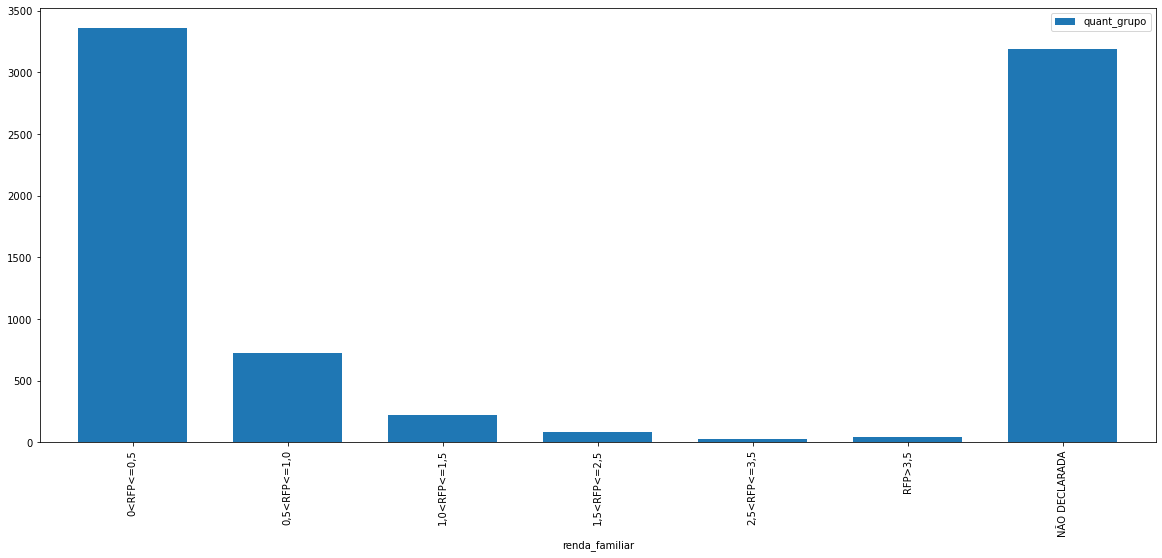

In [13]:
df_qtd.plot(kind ='bar', figsize=(20, 8), width = 0.7)

<AxesSubplot:xlabel='renda_familiar'>

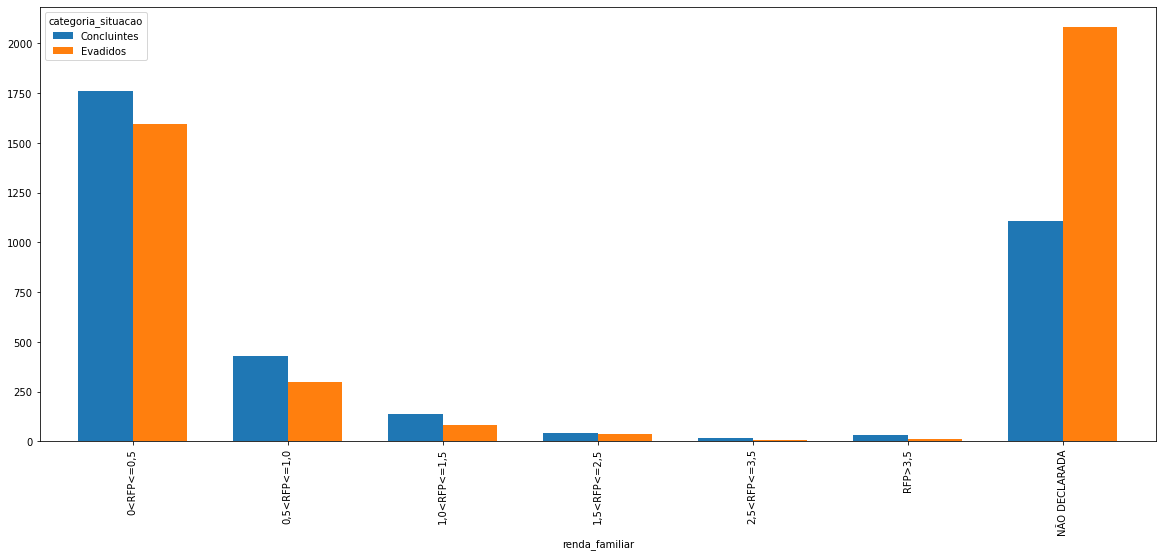

In [14]:
df_cat.plot(kind ='bar', figsize=(20, 8), width = 0.7)

## Total de Alunos

In [15]:
categories = list(df['categoria_situacao'].unique())
total = df['quant_grupo'].sum()
df_res = df_cat 
df_res['total'] = df_res[categories].sum(axis=1)
for category in categories:
    df_res[category + '_%'] = df_res[category] / df_res['total']
df_res['total_%'] = df_res['total'] / total
df_res

categoria_situacao,Concluintes,Evadidos,total,Concluintes_%,Evadidos_%,total_%
renda_familiar,,,,,,
"0<RFP<=0,5",1760,1597,3357,0.524278,0.475722,0.439513
"0,5<RFP<=1,0",427,299,726,0.588154,0.411846,0.095051
"1,0<RFP<=1,5",138,80,218,0.633028,0.366972,0.028542
"1,5<RFP<=2,5",44,39,83,0.530120,0.469880,0.010867
"2,5<RFP<=3,5",16,9,25,0.640000,0.360000,0.003273
"RFP>3,5",31,12,43,0.720930,0.279070,0.005630
NÃO DECLARADA,1105,2081,3186,0.346830,0.653170,0.417125


In [16]:
print("Total de alunos: {:,}".format(df['quant_grupo'].sum()).replace(',','.'))

Total de alunos: 7.638


# Porcentagem de Conclusão

<AxesSubplot:xlabel='renda_familiar'>

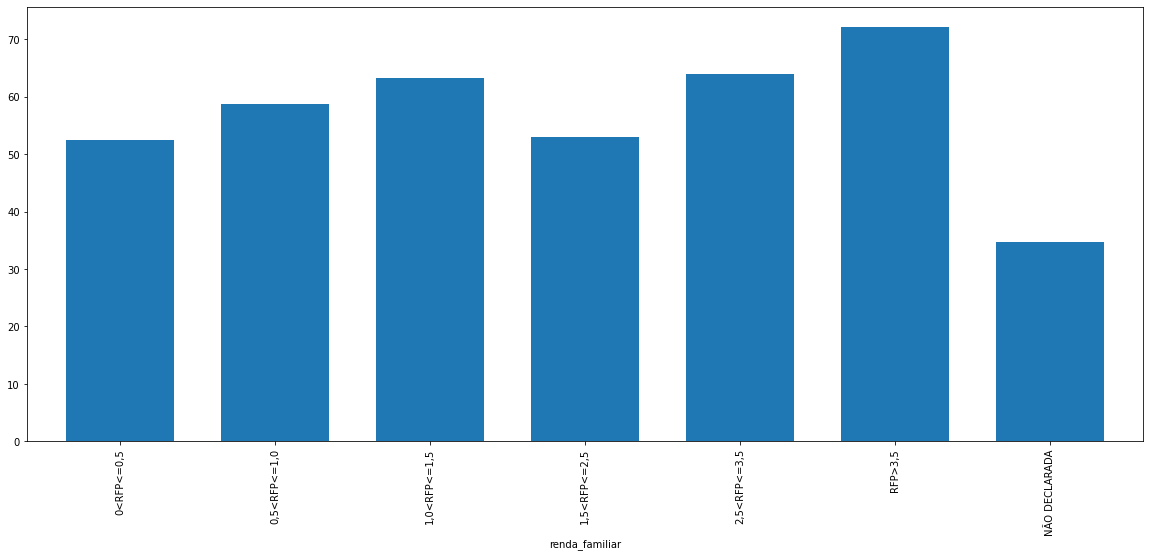

In [17]:
df_drp = df_res['Concluintes_%'] * 100

df_drp.plot(kind ='bar', figsize=(20, 8), width = 0.7)